# Lab 5

Daniel Alfredo Rayo Roldan

Gerardo Gabriel Pineda Riveiro

https://github.com/DanielRasho/DS-lab6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords as nltk_stop
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import warnings
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("./data/train.csv")

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print(f"Número de filas: {df_train.shape[0]}")
print(f"Número de columnas: {df_train.shape[1]}")
print(f"\nColumnas: {list(df_train.columns)}")
print(f"\nTipos de datos:")
df_train.dtypes

Número de filas: 7613
Número de columnas: 5

Columnas: ['id', 'keyword', 'location', 'text', 'target']

Tipos de datos:


id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

## Análisis Exploratorio

### Valores faltantes

In [4]:
missing_values = df_train.isnull().sum()
missing_percent = (missing_values / len(df_train)) * 100

missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores Faltantes': missing_values.values,
    'Porcentaje': missing_percent.values
})
missing_df

,Columna,Valores Faltantes,Porcentaje
0,id,0,0.000000
1,keyword,61,0.801261
2,location,2533,33.272035
3,text,0,0.000000
4,target,0,0.000000


### Distribución de variable objetivo

Tweets NO desastre (0): 4342 (57.0%)
Tweets de desastre (1): 3271 (43.0%)


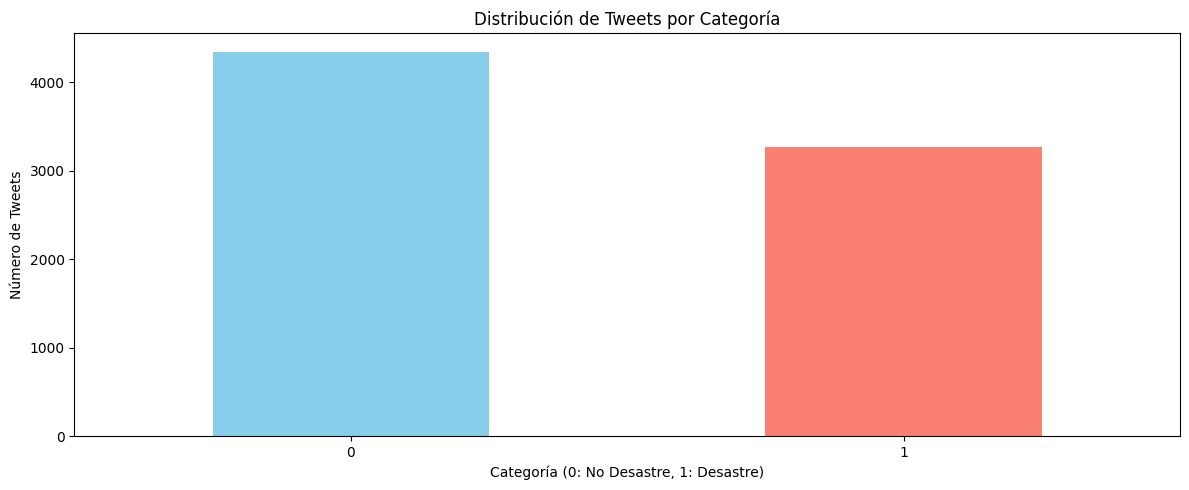

In [5]:
# Distribución de la variable objetivo
target_counts = df_train['target'].value_counts()
print(f"Tweets NO desastre (0): {target_counts[0]} ({target_counts[0]/len(df_train)*100:.1f}%)")
print(f"Tweets de desastre (1): {target_counts[1]} ({target_counts[1]/len(df_train)*100:.1f}%)")

# Visualización de la distribución
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))

# Gráfico de barras
target_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Distribución de Tweets por Categoría')
ax1.set_xlabel('Categoría (0: No Desastre, 1: Desastre)')
ax1.set_ylabel('Número de Tweets')
ax1.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [6]:
# Ejemplos de tweets por categoría
print("\n=== EJEMPLOS DE TWEETS ===")
print("Tweets de DESASTRE:")
for i, tweet in enumerate(df_train[df_train['target']==1]['text'].head(3)):
    print(f"{i+1}. {tweet}")

print("\nTweets NO de desastre:")
for i, tweet in enumerate(df_train[df_train['target']==0]['text'].head(3)):
    print(f"{i+1}. {tweet}")


=== EJEMPLOS DE TWEETS ===
Tweets de DESASTRE:
1. Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
2. Forest fire near La Ronge Sask. Canada
3. All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

Tweets NO de desastre:
1. What's up man?
2. I love fruits
3. Summer is lovely


# Preprocesamiento

In [7]:
nltk.download("stopwords"); nltk.download("wordnet"); nltk.download("omw-1.4")
tt = TweetTokenizer(preserve_case=not True, reduce_len=True, strip_handles=False)
wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/smaug/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/smaug/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/smaug/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
stopwords = set(nltk_stop.words("english"))
negs = {"no","not","n't"}
stopwords = {w for w in stopwords if w.lower() not in negs}

In [9]:
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
APOSTROPHES_RE = re.compile(r"[’`´]")
EMOJI_RE = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE
)
NUMBER_RE = re.compile(r"\b\d+(?:[.,]\d+)*\b")

PUNCT_TABLE = str.maketrans("", "", string.punctuation)

In [10]:
def count_pattern(pat, text):
    return len(pat.findall(text))

def clean_raw(text: str) -> dict:
    original = text

    
    text = text.lower()

    urls = mentions = emojis = hashtags = numbers = 0

    urls = count_pattern(URL_RE, text)
    text = URL_RE.sub(" ", text)

    mentions = count_pattern(MENTION_RE, text)
    text = MENTION_RE.sub(" ", text)

    hashtags = count_pattern(HASHTAG_RE, text)
    text = HASHTAG_RE.sub(lambda m: m.group(1), text)

    text = APOSTROPHES_RE.sub("'", text)

    if True: # Cambiar esto para cambiarlos emojis (si queres rayo)
        emojis = len(EMOJI_RE.findall(text))
        text = EMOJI_RE.sub(" ", text)

    # Aqui estan los numeros solo vamos a dejar el 911
    def num_filter(m):
        tok = m.group(0)
        return tok if tok in {"911"} else " "
    numbers = len(NUMBER_RE.findall(text))
    text = NUMBER_RE.sub(num_filter, text)

    text = text.translate(PUNCT_TABLE)

    text = re.sub(r"\s+", " ", text).strip()

    return {
        "text_raw": original,
        "text_clean_raw": text,
        "urls_removed": urls,
        "mentions_removed": mentions,
        "emojis_removed": emojis,
        "hashtags_unhashed": hashtags,
        "numbers_affected": numbers
    }

clean_rows = df_train["text"].map(clean_raw)
clean_df = pd.DataFrame(list(clean_rows))
df_train = pd.concat([df_train, clean_df], axis=1)

In [11]:
def tokenize_and_normalize(text: str):
    tokens = []
    toks = tt.tokenize(text)
    toks = [t for t in toks if all(ch not in string.punctuation for ch in t)]
    toks = [wnl.lemmatize(t) for t in toks]
    # stopwords
    toks = [t for t in toks if t.lower() not in stopwords]
    tokens = toks

    tokens = [t.strip() for t in tokens if t.strip() != ""]
    return tokens

df_train["tokens"] = df_train["text_clean_raw"].map(tokenize_and_normalize)
df_train["text_clean"] = df_train["tokens"].map(lambda ts: " ".join(ts))

In [12]:
df_train["len_raw"] = df_train["text"].str.split().map(len)
df_train["len_clean"] = df_train["tokens"].map(len)

In [13]:
print(df_train[["text_clean_raw","tokens","text_clean"]].head(1))

                                      text_clean_raw  \
0  our deeds are the reason of this earthquake ma...   

                                              tokens  \
0  [deed, reason, earthquake, may, allah, forgive...   

                                   text_clean  
0  deed reason earthquake may allah forgive u  


### Frecuencia de palabras por categoría

In [16]:
# Separar textos por categoría
disaster_tweets = df_train[df_train['target'] == 1]['text_clean']
non_disaster_tweets = df_train[df_train['target'] == 0]['text_clean']

# Función para obtener frecuencias de palabras
def get_word_frequencies(texts, top_n=20):
    """
    Obtiene las palabras más frecuentes de una lista de textos
    """
    all_words = []
    for text in texts:
        words = text.split()
        all_words.extend(words)
    
    return Counter(all_words).most_common(top_n)

# Obtener palabras más frecuentes para cada categoría
disaster_freq = get_word_frequencies(disaster_tweets)
non_disaster_freq = get_word_frequencies(non_disaster_tweets)

print("TOP 20 PALABRAS MÁS FRECUENTES - TWEETS DE DESASTRE:")
for word, freq in disaster_freq:
    print(f"{word}: {freq}")

print("\nTOP 20 PALABRAS MÁS FRECUENTES - TWEETS NO DE DESASTRE:")
for word, freq in non_disaster_freq:
    print(f"{word}: {freq}")

TOP 20 PALABRAS MÁS FRECUENTES - TWEETS DE DESASTRE:
: 372
fire: 265
û: 213
wa: 174
news: 136
via: 121
disaster: 117
california: 115
suicide: 110
amp: 109
no: 108
police: 107
people: 106
u: 105
family: 105
ha: 105
home: 101
train: 100
building: 95
not: 93

TOP 20 PALABRAS MÁS FRECUENTES - TWEETS NO DE DESASTRE:
: 412
like: 255
im: 244
û: 224
wa: 219
not: 204
amp: 193
get: 185
new: 170
ha: 151
no: 146
u: 146
dont: 141
one: 136
body: 117
time: 104
video: 102
via: 99
would: 97
day: 96


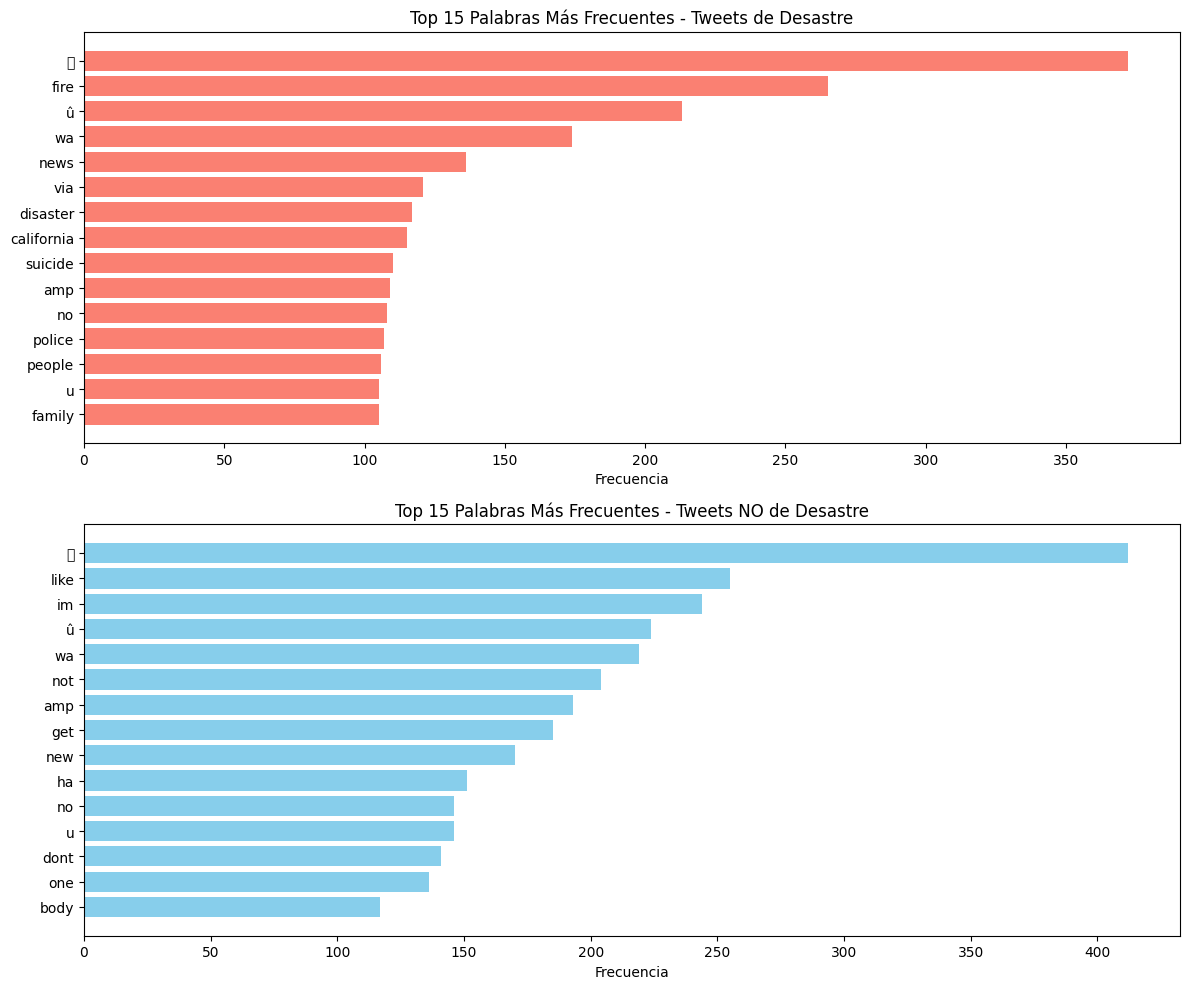

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Palabras más frecuentes en tweets de desastre
disaster_words = [word for word, freq in disaster_freq]
disaster_counts = [freq for word, freq in disaster_freq]

ax1.barh(disaster_words[:15][::-1], disaster_counts[:15][::-1], color='salmon')
ax1.set_title('Top 15 Palabras Más Frecuentes - Tweets de Desastre')
ax1.set_xlabel('Frecuencia')

# Palabras más frecuentes en tweets NO de desastre
non_disaster_words = [word for word, freq in non_disaster_freq]
non_disaster_counts = [freq for word, freq in non_disaster_freq]

ax2.barh(non_disaster_words[:15][::-1], non_disaster_counts[:15][::-1], color='skyblue')
ax2.set_title('Top 15 Palabras Más Frecuentes - Tweets NO de Desastre')
ax2.set_xlabel('Frecuencia')

plt.tight_layout()
plt.show()

### Analísis de Bigramas y Trigramas

#### Bigramas

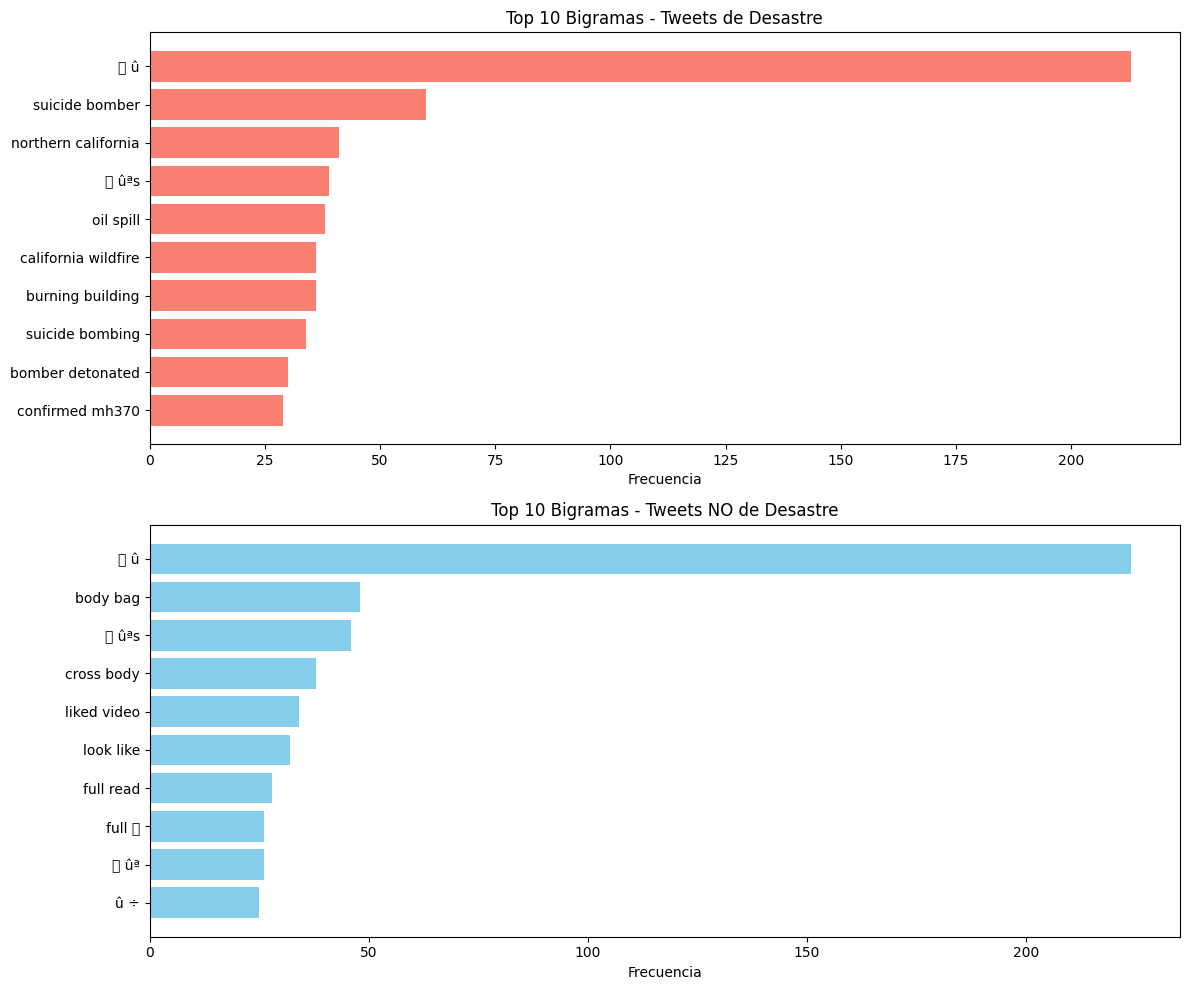

In [18]:
def get_ngrams(texts, n=2, top_n=15):
    """
    Obtiene los n-gramas más frecuentes
    """
    all_ngrams = []
    for text in texts:
        words = text.split()
        if len(words) >= n:
            text_ngrams = list(ngrams(words, n))
            all_ngrams.extend(text_ngrams)
    
    ngram_freq = Counter(all_ngrams)
    return ngram_freq.most_common(top_n)

# Obtener bigramas más frecuentes
disaster_bigrams = get_ngrams(disaster_tweets, n=2, top_n=15)
non_disaster_bigrams = get_ngrams(non_disaster_tweets, n=2, top_n=15)

# Visualización de bigramas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Bigramas de tweets de desastre
disaster_bigram_labels = [' '.join(bigram) for bigram, freq in disaster_bigrams]
disaster_bigram_counts = [freq for bigram, freq in disaster_bigrams]

ax1.barh(disaster_bigram_labels[:10][::-1], disaster_bigram_counts[:10][::-1], color='salmon')
ax1.set_title('Top 10 Bigramas - Tweets de Desastre')
ax1.set_xlabel('Frecuencia')

# Bigramas de tweets NO de desastre
non_disaster_bigram_labels = [' '.join(bigram) for bigram, freq in non_disaster_bigrams]
non_disaster_bigram_counts = [freq for bigram, freq in non_disaster_bigrams]

ax2.barh(non_disaster_bigram_labels[:10][::-1], non_disaster_bigram_counts[:10][::-1], color='skyblue')
ax2.set_title('Top 10 Bigramas - Tweets NO de Desastre')
ax2.set_xlabel('Frecuencia')

plt.tight_layout()
plt.show()


#### Trigramas

In [20]:
disaster_trigrams = get_ngrams(disaster_tweets, n=3, top_n=10)
non_disaster_trigrams = get_ngrams(non_disaster_tweets, n=3, top_n=10)

print("\nTOP 10 TRIGRAMAS - TWEETS DE DESASTRE:")
for trigram, freq in disaster_trigrams:
    print(f"{' '.join(trigram)}: {freq}")

print("\nTOP 10 TRIGRAMAS - TWEETS NO DE DESASTRE:")
for trigram, freq in non_disaster_trigrams:
    print(f"{' '.join(trigram)}: {freq}")


TOP 10 TRIGRAMAS - TWEETS DE DESASTRE:
suicide bomber detonated: 30
northern california wildfire: 29
latest home razed: 28
home razed northern: 28
pkk suicide bomber: 28
bomber detonated bomb: 28
razed northern california: 27
16yr old pkk: 27
old pkk suicide: 27
family sue legionnaire: 26

TOP 10 TRIGRAMAS - TWEETS NO DE DESASTRE:
 û ÷: 25
full  û: 25
cross body bag: 23
 û : 22
reddit quarantine offensive: 19
quarantine offensive content: 18
pick fan army: 17
reddits new content: 16
new content policy: 16
stock market crash: 16


## Modelos de Clasificación de sentimientos

In [21]:
analyzer_vader = SentimentIntensityAnalyzer()

print("Aplicando VADER Sentiment...")

def analyze_vader_sentiment(text):
    """
    Analiza sentimiento con VADER
    """
    scores = analyzer_vader.polarity_scores(text)
    compound = scores['compound']
    
    if compound >= 0.05:
        return 'positive', compound, scores
    elif compound <= -0.05:
        return 'negative', compound, scores
    else:
        return 'neutral', compound, scores

vader_results = df_train['text_sentiment'].apply(analyze_vader_sentiment)
df_train['vader_sentiment'] = [r[0] for r in vader_results]
df_train['vader_compound'] = [r[1] for r in vader_results]
df_train['vader_scores'] = [r[2] for r in vader_results]

Aplicando VADER Sentiment...


KeyError: 'text_sentiment'

## Modelos de clasificación de palabras